In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import os
os.chdir('/content/drive/My Drive/P3')

# Watch out for unexpected movie recommendations !

# Introduction

Our project will use LDA on movies' synopsis to assign themes to the movies. In this notebook, we will start from the raw movies dataset and add the synopsis, the ratings and the box-offices from other datasets. We then perform an in-depth analysis of the obtained dataset to understand what we have in hands. We finish with a quick feasibility-check of the LDA method.

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Analysis</p>
    <div style="padding: 0 0 2px 10px;">
    
**What will be covered :**
- **Part 1 :** Data importation and exploration
- **Part 2 :** Data Analysis
- **Part 3 :** Is LDA a feasible method for our data ?

</div></div>
<br/>

---

# Part 1: Data Exploration and Processing

### Import libraries

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.offline as pyo
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import Image

# Setting notebook to work offline
pyo.init_notebook_mode()
import ast
import os
import sys
sys.path.append(os.path.abspath("src/utils"))
from helpers import *

# LDA
import spacy
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
# gensim is a popular library for topic modelling
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pickle

from imdb import IMDb
import re
import kagglehub # To extract synopsis dataframes

Output hidden; open in https://colab.research.google.com to view.

## 1.1 Dataset exploration

### Load initial movie dataset

In [23]:
print("Current Directory:", os.getcwd())

Current Directory: /content/drive/MyDrive/P3


In [24]:
movie_columnns =['Wikipedia movie ID','Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']
movie = pd.read_csv('Data/movie.metadata.tsv', sep='\t', header=None, names=movie_columnns)

print('The dataset contains', movie.shape[0], 'movies and',movie.shape[1] , 'features.')
movie.head()

The dataset contains 81741 movies and 9 features.


,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


## Features Descriptions

| Column                | Description                                                                        |
|-----------------------|------------------------------------------------------------------------------------|
| Wikipedia movie ID    | An identifier for each movie from Wikipedia.                                       |
| Freebase movie ID     | A unique identifier for each movie from the Freebase database.                     |
| Movie name            | The title of the movie.                                                            |
| Movie release date    | The date when the movie was released, formatted as `YYYY-MM-DD`.                   |
| Movie box office revenue | The revenue generated by the movie at the box office (in dollars). |
| Movie runtime         | The duration of the movie in minutes. |
| Movie languages       | A dictionary where keys represent Freebase language IDs, and values represent the language names (e.g., English, Norwegian, German). |
| Movie countries       | A dictionary where keys are Freebase country IDs, and values are country names representing where the movie was produced. |
| Movie genres          | A dictionary where each key represents a Freebase genre ID, and each value represents the corresponding genre of the movie. |

### Comment
Not all features will be useful to our analysis:
- The `Freebase movie ID` is no longer actively used
- `Movie runtime` is not used in the analysis

So both of those features will be dropped.

#### Drop columns

In [25]:
# Creat new df with updated columns
movie_drop = movie.drop(['Freebase movie ID', 'Movie runtime'], axis=1)

# Visual check
movie_drop.columns

Index(['Wikipedia movie ID', 'Movie name', 'Movie release date',
       'Movie box office revenue', 'Movie languages', 'Movie countries',
       'Movie genres'],
      dtype='object')

Both columns have been efficiently dropped.

## Features types

In [26]:
pd.DataFrame(movie_drop.dtypes, columns=['Type'])

,Type
Wikipedia movie ID,int64
Movie name,object
Movie release date,object
Movie box office revenue,float64
Movie languages,object
Movie countries,object
Movie genres,object


### Comment
1. The `Movie languages`, `Movie countries` and `Movie genres` are stored in dictionnaries with `Freebase movie ID` as keys. Since the `Freebase movie ID` are not kept the dictionnaries will be changed to keep values only.

2. For our analysis, having the full release date in `Movie release date` isn't necessary, just the year is enough. Therefore, we convert the release date into a year format (e.g. 1995-07-21 becomes 1995).

Since for our analysis we are not interested in the movie runtime we drop this column too.

In [27]:
movies_df = movie_drop.copy()
movies_df['Movie genres'] = convert_to_list(movies_df, 'Movie genres')
movies_df['Movie languages'] = convert_to_list(movies_df, 'Movie languages')
movies_df['Movie countries'] = convert_to_list(movies_df, 'Movie countries')

movies_df[['Movie genres','Movie languages', 'Movie countries']].head()

,Movie genres,Movie languages,Movie countries
0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America]
1,"[Mystery, Biographical film, Drama, Crime Drama]",[English Language],[United States of America]
2,"[Crime Fiction, Drama]",[Norwegian Language],[Norway]
3,"[Thriller, Erotic thriller, Psychological thri...",[English Language],[United Kingdom]
4,[Drama],[German Language],[Germany]


We can now see that the columns containing information about movie languages, countries, and genres are indeed formatted as lists.

In [28]:
# Convert string to year
movies_df['Movie release date'] = movies_df['Movie release date'].apply(extract_year).astype('Int64')

# Check that all movies release dates are encoded in years
print(movies_df['Movie release date'].head())

0    2001
1    2000
2    1988
3    1987
4    1983
Name: Movie release date, dtype: Int64


The release dates are now in years format!

# 1.2 Getting Synopses
To discover the underlying topics of the movies with LDA we will need the synopses. We decide not to use the movies summaries since they encode significantly less context and would result in less confident clustering. Here is a quick comparison of the synopses vs summaries.

## Summaries vs Synopses

In [29]:
# Load dataset
sum_columns = ['Wikipedia movie ID','Plot summary']
sum_df = pd.read_csv('Data/plot_summaries.txt', sep='\t', header=None, names=sum_columns)
# Check data shape
print("This summaries dataframe is of size:", sum_df.shape)
sum_df.head()

This summaries dataframe is of size: (42303, 2)


,Wikipedia movie ID,Plot summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [30]:
# Length of each plot summary
sum_df['summary_length'] = sum_df['Plot summary'].apply(len)
sum_df['summary_length'].describe().round(0)

,summary_length
count,42303.0
mean,1784.0
std,1809.0
min,99.0
25%,508.0
50%,1079.0
75%,2604.0
max,28159.0


### Comment
- Nbr of summaries: We have the summaries of 42'303 movies
- Movie Description: Most of the summaries contain between 508 an 2604 strings, which is a non-exhaustive description

## Synopses
For synopses the MPST dataset is used, this dataset is usually used for supervised learning of tags prediction using plot synopsis.


In [31]:
# Load data
synopsis = pd.read_csv('Data/mpst_full_data.csv')

# Check data shape
print("This synopsis dataframe is of size:", synopsis.shape)

# Display df
synopsis.head()

This synopsis dataframe is of size: (14828, 6)


,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


In [32]:
# Length of each synopsis
size_synopsis = synopsis.copy()
size_synopsis['plot_length'] = synopsis['plot_synopsis'].apply(len)
size_synopsis['plot_length'].describe().round(0)

,plot_length
count,14828.0
mean,5140.0
std,4940.0
min,442.0
25%,2495.0
50%,3827.0
75%,5760.0
max,63959.0


### Comment: Summaries vs Synopses
- Extra Infromation: The MPST dataset offers extra information such as `tags` which are topics!
- More context: The full movie synopsis which would give the LDA more context to group movies together with descriptions that contain mostly between 2495 to 5760 strings
- Less movies: On the other hand there are only 14'828 movies which is consequently smaller than the initial dataframe. We make the choice to reduce the dataset but gain precision on the themes generated by the LDA.

Conclusion: For the rest of the analysis the MPST dataset is used

Note: Another important notice is that this dataframe uses imdb_id not wikipedia movie ids.

### MPST Features
| Column                | Description                                                                        |
|-----------------------|------------------------------------------------------------------------------------|
| imdb_id	    | An identifier for each movie from IMdB.                                       |
| plot_synopsis	     | Whole movie plot description.                     |
| title            | The title of the movie.                                                            |
| tags	    | Topics present in the movie..                   |
| split | Describe if used for training, validation or testing. |
| synopsis_source         | Plateform from which the synopsis. |


### Comment
Not all features will be useful to our analysis:
- The `split` feature is not relevant since we perform an unsupervised analysis
- `synopsis_source` is not used in the analysis

So both of those features will be dropped.

## Combinig both datasets

In [33]:
# Merge by matching titles
movies_syn = synopsis.merge(movies_df, left_on='title', right_on='Movie name', how='inner')

# Remove columns
movies_syn.drop(columns=['title', 'split', 'synopsis_source'], inplace=True)

# Display
movies_syn.head()

,imdb_id,plot_synopsis,tags,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie languages,Movie countries,Movie genres
0,tt1733125,"Two thousand years ago, Nhagruul the Foul, a s...",violence,30855958,Dungeons & Dragons: The Book of Vile Darkness,2012,NaN,[],[United Kingdom],[Fantasy]
1,tt0033045,"Matuschek's, a gift store in Budapest, is the ...",romantic,76353,The Shop Around the Corner,1940,NaN,[English Language],[United States of America],"[Romantic comedy, Workplace Comedy, Black-and-..."
2,tt0113862,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",171076,Mr. Holland's Opus,1995,106269971.0,"[English Language, American Sign Language]",[United States of America],"[Inspirational Drama, Family Film, Drama, Musi..."
3,tt0086250,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",76331,Scarface,1932,NaN,"[Italian Language, English Language]",[United States of America],"[Crime Fiction, Gangster Film, Black-and-white..."
4,tt0086250,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",267848,Scarface,1983,65884703.0,"[English Language, Spanish Language]",[United States of America],"[Crime Fiction, Thriller, Gangster Film, Actio..."


### How many movies have no matching synopsis?

In [34]:
# Compare size before and after merge
lost_rows = synopsis.shape[0] - movies_syn.shape[0]
print(f"We only lost {lost_rows} movies by merging the two dataset by the titles of the movies.")

We only lost 94 movies by merging the two dataset by the titles of the movies.


### Comment

1. Movie loss: The size fo the dataframe has not significantly changed, only 94 movies did not match. Our original movie df contained most of the movies present in the synopsis df.

2. Same title: We also observe that Scarface appears twice since there was a remake. For the rest for the analysis we will assume that if the name of the movie is exactly the same, the synopsis is pretty similar for both movies (if not the same!).

# 1.3 Getting Ratings
Rating reflect important information when talking about recommendation. They directly reflect how much someone enjoyed a movie.
Thus we found an IMdB dataset online which contains movie ratings.

In [35]:
# Load dataset
ratings_df = pd.read_csv('Data/title.ratings.tsv', sep='\t')
ratings_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2100
1,tt0000002,5.6,282
2,tt0000003,6.5,2119
3,tt0000004,5.4,182
4,tt0000005,6.2,2850


### Columns
| Feature         | Description                                      |
|-----------------|--------------------------------------------------|
| tconst          | IMDb ID (unique identifier for a movie)           |
| average rating  | Mean of all ratings given to the movie           |
| numVotes        | Number of people who rated the movie             |

Since both of our datasets contain information about the `imdb_id`, we can merge them using this information.

## Merging both datasets

In [36]:
# Merge
movies_ratings = pd.merge(movies_syn,ratings_df,left_on='imdb_id', right_on='tconst',how='inner')

# Remove redundant columns
movies_ratings = movies_ratings.drop(['tconst'], axis=1)

# Display
movies_ratings.head(3)

,imdb_id,plot_synopsis,tags,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie languages,Movie countries,Movie genres,averageRating,numVotes
0,tt1733125,"Two thousand years ago, Nhagruul the Foul, a s...",violence,30855958,Dungeons & Dragons: The Book of Vile Darkness,2012,NaN,[],[United Kingdom],[Fantasy],4.4,2722
1,tt0033045,"Matuschek's, a gift store in Budapest, is the ...",romantic,76353,The Shop Around the Corner,1940,NaN,[English Language],[United States of America],"[Romantic comedy, Workplace Comedy, Black-and-...",8.0,39430
2,tt0113862,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",171076,Mr. Holland's Opus,1995,106269971.0,"[English Language, American Sign Language]",[United States of America],"[Inspirational Drama, Family Film, Drama, Musi...",7.3,42246


## Comment: Complete Dataset
Our dataset is complete! We can start to analyse the data.

In [37]:
# save .csv file to import it in box_office_extraction.py
movies_ratings.to_csv('Data/movies_ratings.csv', index=False)

# Part 2: Data Analysis

## Part 2.1 Handling Missing Values

Our dataset is now complete for the analysis, however we need to check the NaN values before.

In [38]:
# Replace empty lists with NaN
movies_ratings = movies_ratings.applymap(replace_empty_with_nan)
movies_ratings.head()

<ipython-input-38-1185dedafc32>:2: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,imdb_id,plot_synopsis,tags,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie languages,Movie countries,Movie genres,averageRating,numVotes
0,tt1733125,"Two thousand years ago, Nhagruul the Foul, a s...",violence,30855958,Dungeons & Dragons: The Book of Vile Darkness,2012.0,NaN,NaN,[United Kingdom],[Fantasy],4.4,2722
1,tt0033045,"Matuschek's, a gift store in Budapest, is the ...",romantic,76353,The Shop Around the Corner,1940.0,NaN,[English Language],[United States of America],"[Romantic comedy, Workplace Comedy, Black-and-...",8.0,39430
2,tt0113862,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",171076,Mr. Holland's Opus,1995.0,106269971.0,"[English Language, American Sign Language]",[United States of America],"[Inspirational Drama, Family Film, Drama, Musi...",7.3,42246
3,tt0086250,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",76331,Scarface,1932.0,NaN,"[Italian Language, English Language]",[United States of America],"[Crime Fiction, Gangster Film, Black-and-white...",8.3,939727
4,tt0086250,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",267848,Scarface,1983.0,65884703.0,"[English Language, Spanish Language]",[United States of America],"[Crime Fiction, Thriller, Gangster Film, Actio...",8.3,939727


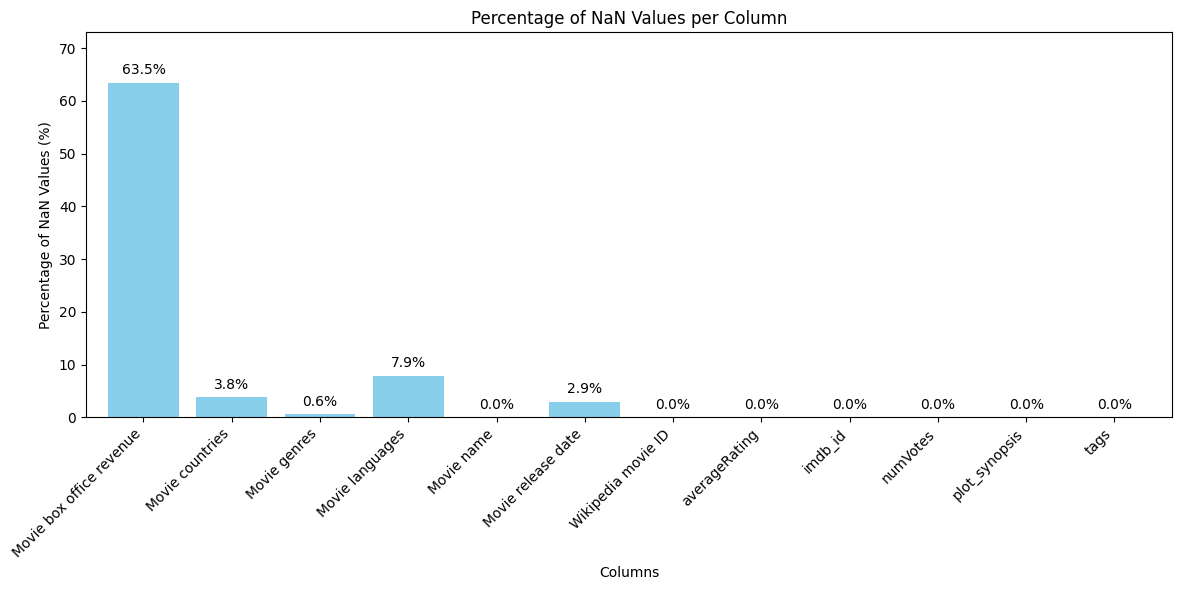

In [39]:
# Calculate percentage of NaN values in each column
na_percentage = (movies_ratings.isna().sum() / len(movies_ratings)) * 100
na_percentage = na_percentage.sort_index()

# Plot
plt.figure(figsize=(12, 6))
bars = na_percentage.plot(kind='bar', color='skyblue', width=0.8)

# Add percentage labels on top of each bar
for i, value in enumerate(na_percentage):
    plt.text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom', fontsize=10)

plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage of NaN Values (%)')
plt.ylim(top =73)
plt.title('Percentage of NaN Values per Column')
plt.tight_layout()

plt.show()


Five columns contain Missing values:
- `Movie box office revenue` which has 63.5% of missing values, is very problematic, since this feature is used to answer some research questions. We will try to find external information to fill the gaps.
- `Movie languages` with 7.9% of NaNs
- `Movie countries` with 3.8% of NaNs
- `Movie release date` with 2.9% of missing values
- `Movie genres` with 0.6% of NanS

### Handling Nans for Movie box office revenue
Since the number of NaNs in the box-office revenue column is significant we try to enrich the dataset with data from IMbD.

The code to extract the box office with the IMdB library can be found in the `src/scripts/box_office_extraction.py` file. The run time is very long, therefore we run it one time and save the results in a .csv file that we import here.

In [40]:
#Here is the file with completed box-office from Imdb (last column)
new_movies_dataset = pd.read_csv('Data/movies_synopsis_comp.csv')

# Add IMDB box office to original dataset
IMDB_box_office = new_movies_dataset['IMDB Box-office']

movies_ratings['IMDB Box-office'] = IMDB_box_office

display(movies_ratings.head(3))

,imdb_id,plot_synopsis,tags,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie languages,Movie countries,Movie genres,averageRating,numVotes,IMDB Box-office
0,tt1733125,"Two thousand years ago, Nhagruul the Foul, a s...",violence,30855958,Dungeons & Dragons: The Book of Vile Darkness,2012.0,NaN,NaN,[United Kingdom],[Fantasy],4.4,2722,NaN
1,tt0033045,"Matuschek's, a gift store in Budapest, is the ...",romantic,76353,The Shop Around the Corner,1940.0,NaN,[English Language],[United States of America],"[Romantic comedy, Workplace Comedy, Black-and-...",8.0,39430,380000.0
2,tt0113862,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",171076,Mr. Holland's Opus,1995.0,106269971.0,"[English Language, American Sign Language]",[United States of America],"[Inspirational Drama, Family Film, Drama, Musi...",7.3,42246,106269971.0


In [41]:
movies_synopsis_comp = movies_ratings.copy() #Just a matter of changing the name of the df

### Comment

We completed some of the missing data, but how much did we improve ?

In [42]:
#Improvement in NaN values in box-office
na_percentage_box_init = (movies_synopsis_comp['Movie box office revenue'].isna().sum() / len(movies_synopsis_comp)) * 100
na_percentage_box_imdb = (movies_synopsis_comp['IMDB Box-office'].isna().sum() / len(movies_synopsis_comp)) * 100
print(f"We went from {round(na_percentage_box_init,2)}% of NaN values to {round(na_percentage_box_imdb,2)}%.")

We went from 63.47% of NaN values to 54.8%.


### Comment
The increase is a bit deceiving. The IMDB library is missing a lot of box-offices too. We suspect the IMDB library to maybe block requests when there are too many, giving more NaN values than there actually are. In the end that's still an increase of 24% in box-office data size, which will help us for our analysis.

In the upcoming weeks (for P3), we will assess whether the available data is sufficient to draw meaningful conclusions; otherwise, we may need to explore alternative sources for additional box-office data.

In [43]:
#Remove the old revenue column as we don't need it anymore
movies_synopsis_comp.drop('Movie box office revenue', axis=1, inplace=True)

### Handling Nans for Movie release dates
We remove movies with no information on Movie release dates since we are interested in the release years.

In [44]:
# Drop all movies with no Movie release dates
movies_df_cleaned = movies_synopsis_comp.dropna(subset=['Movie release date'])

# Check missing values
movies_df_cleaned['Movie release date'].isna().any()
print(movies_ratings.shape[0]-movies_df_cleaned.shape[0], "movies have no release dates and were removed from the dataset")

433 movies have no release dates and were removed from the dataset


Comment: in the following weeks we will assess whether we need to handle the missing values of the other features as well.

## Part 2.2 Data exploration

In [45]:
movie_final = movies_df_cleaned.copy() # deep copy
movie_final.head(3)

,imdb_id,plot_synopsis,tags,Wikipedia movie ID,Movie name,Movie release date,Movie languages,Movie countries,Movie genres,averageRating,numVotes,IMDB Box-office
0,tt1733125,"Two thousand years ago, Nhagruul the Foul, a s...",violence,30855958,Dungeons & Dragons: The Book of Vile Darkness,2012.0,NaN,[United Kingdom],[Fantasy],4.4,2722,NaN
1,tt0033045,"Matuschek's, a gift store in Budapest, is the ...",romantic,76353,The Shop Around the Corner,1940.0,[English Language],[United States of America],"[Romantic comedy, Workplace Comedy, Black-and-...",8.0,39430,380000.0
2,tt0113862,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",171076,Mr. Holland's Opus,1995.0,"[English Language, American Sign Language]",[United States of America],"[Inspirational Drama, Family Film, Drama, Musi...",7.3,42246,106269971.0


### Movies' genres exploration

In [46]:
all_genres = movie_final['Movie genres'].explode() # Changes elements from a list to a row

num_unique_genre = all_genres.nunique() # Creates list which each type of genre in all_genres
print("Number of unique genres:", num_unique_genre)

Number of unique genres: 333


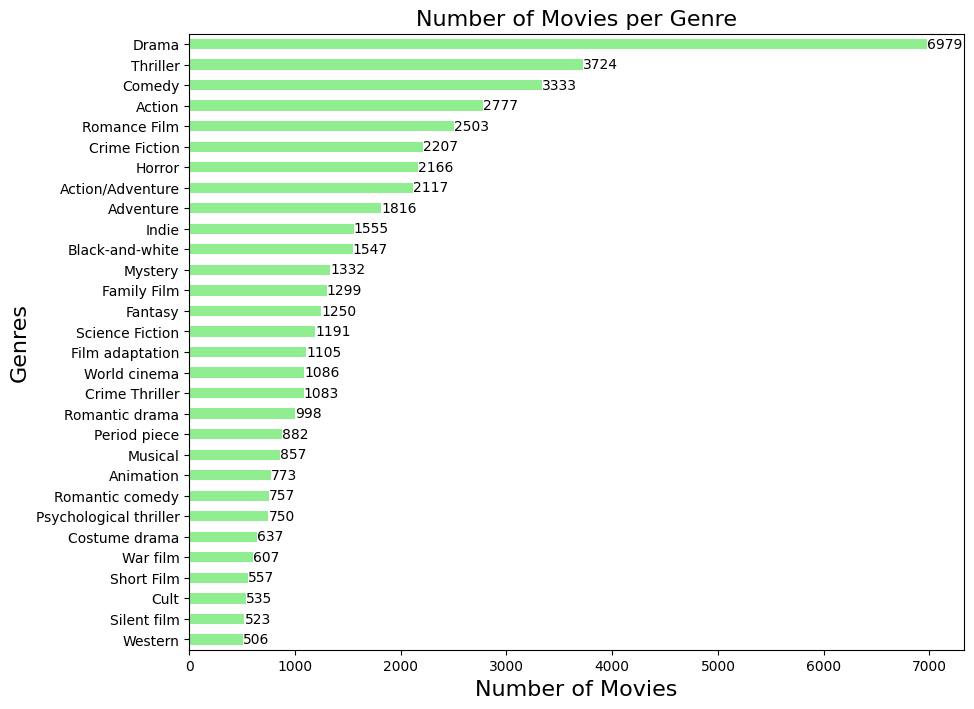

In [47]:
# Plot the number of movies per top 30 genres

genres_counts = all_genres.value_counts()

plt.figure(figsize=(10, 8))
bars = genres_counts.head(30).sort_values(ascending=True).plot(kind='barh', color='lightgreen') # kind='barh' allows us to flip the axis

for index, value in enumerate(genres_counts.head(30).sort_values(ascending=True)):
    plt.text(value, index, str(value), va='center')

plt.xlabel('Number of Movies', fontsize=16)
plt.ylabel('Genres', fontsize=16)
plt.title('Number of Movies per Genre', fontsize=16)

plt.show()

Drama is the clear leader when it comes to movie genres, followed by Comedy and Romance. This makes sense since these genres appeal to a wide range of audiences. Genres like Thriller, Action, and Documentary are also popular, showing that people enjoy excitement and real-life stories. On the other end, niche genres like 'Cult' and 'Political drama' are much less common, which isn't surprising given their more specific audience.

Here we decided to show only the top 30 genres to keep the chart clear and easy to read.

### Movies Box office exploration

In [48]:
movie_final['IMDB Box-office'] = pd.to_numeric(movie_final['IMDB Box-office'], errors='coerce')

# Remove the NaNs to plot
box_office_without_nan = movie_final['IMDB Box-office'].dropna()

For plotting, we select a threshold (4e8) for better visualization as there are some outliers (very large values) that will collapse the plot on the left and make it unreadable.

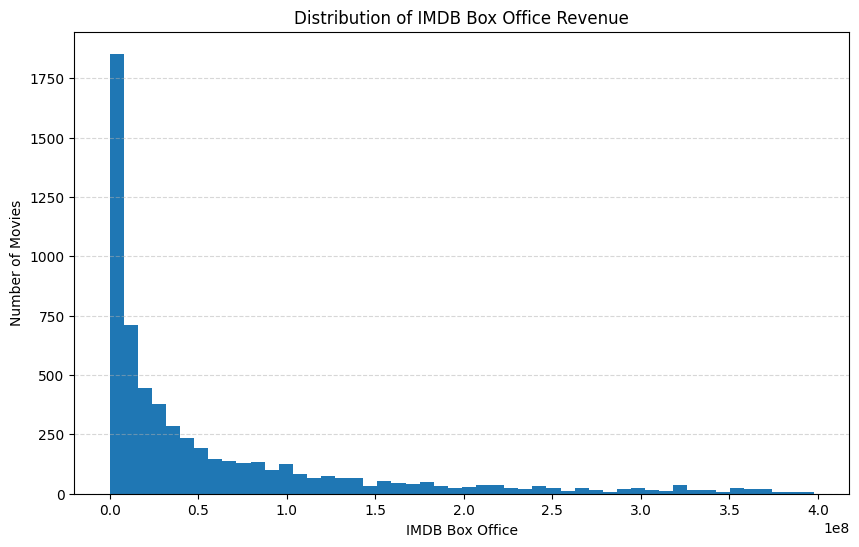

In [49]:
threshold = 4e8
box_office_filtered = movie_final['IMDB Box-office'][movie_final['IMDB Box-office'] < threshold]

# Plot the histogram
box_office_filtered.plot(kind='hist', figsize=(10, 6), bins=50)
plt.xlabel('IMDB Box Office')
plt.ylabel('Number of Movies')
plt.title('Distribution of IMDB Box Office Revenue')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

We observe that most movies results in a small box-office.

### Movies Ratings exploration

In [50]:
movie_final['averageRating'].describe()

,averageRating
count,14253.000000
mean,6.378678
std,1.072958
min,1.300000
25%,5.800000
50%,6.500000
75%,7.100000
max,9.300000


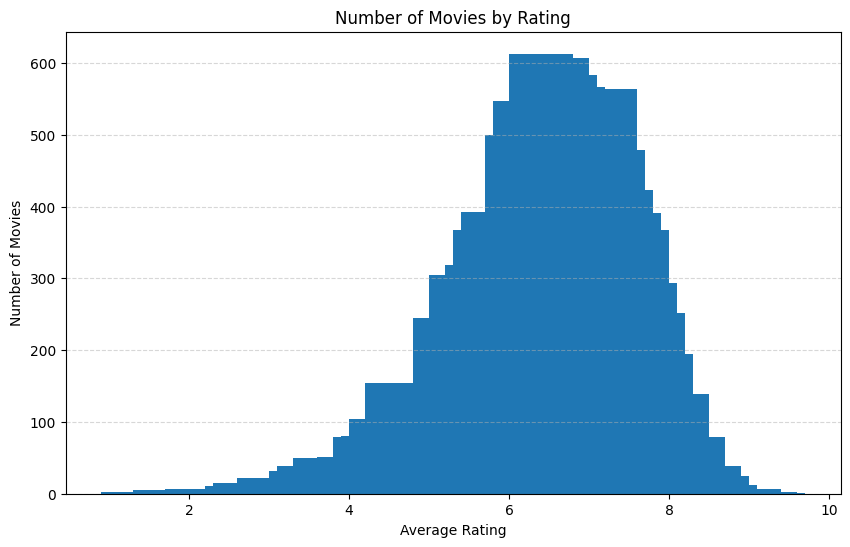

In [51]:
rating_counts = movie_final['averageRating'].value_counts().sort_index()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Rating')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

It seems that raters tend to find movies rather good on average. Extreme ratings are very rare (<1 and >9).

### Movies countries exploration

In [52]:
# Number of movies per country
all_countries = movie_final['Movie countries'].explode()
countries_counts = all_countries.value_counts()
print(countries_counts.head())

Movie countries
United States of America    10205
United Kingdom               2268
France                        757
Germany                       650
India                         647
Name: count, dtype: int64


In [53]:
num_unique_countries = all_countries.nunique()
print("Number of unique countries:", num_unique_countries)

Number of unique countries: 109


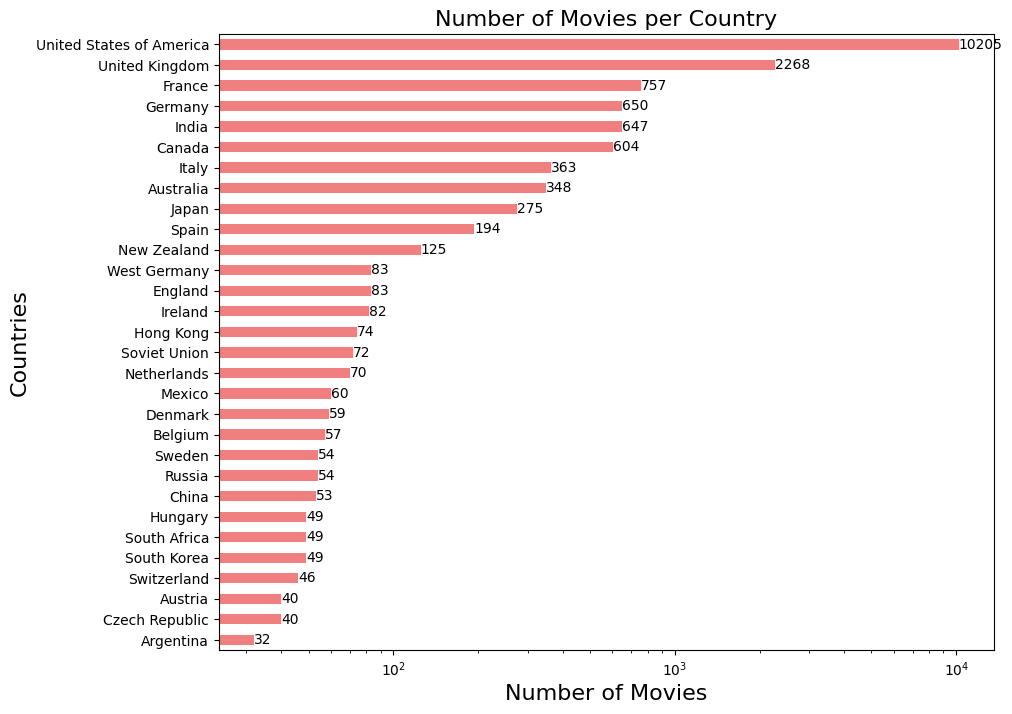

In [54]:
# Plot the top 30 countries with most amount of movies
plt.figure(figsize=(10, 8))
bars = countries_counts.head(30).sort_values(ascending=True).plot(kind='barh', color='lightcoral')

for index, value in enumerate(countries_counts.head(30).sort_values(ascending=True)):
    plt.text(value, index, str(value), va='center')

plt.xlabel('Number of Movies', fontsize=16)
plt.ylabel('Countries', fontsize=16)
plt.title('Number of Movies per Country', fontsize=16)
plt.xscale('log') # Easier to visualise with log scale
plt.show()

The United States has the most movies by far, showing its huge impact on the film industry. The United Kingdoms and France come next, followed by Germany, India and Canada who also produce numerous movies.

We decided to show only the top 30 countries to keep the chart clear and easy to read.

For better readibility we used a log scale on the x axis.

### Movies languages exploration

In [55]:
# Number of movies with a certain language available
all_languages = movie_final['Movie languages'].explode()
language_counts = all_languages.value_counts()
print(language_counts.head())

Movie languages
English Language    11712
French Language       755
Spanish Language      531
Hindi Language        505
German Language       414
Name: count, dtype: int64


In [56]:
num_unique_languages = all_languages.nunique()
print("The dataset contains", num_unique_languages, "unique languages.")

The dataset contains 148 unique languages.


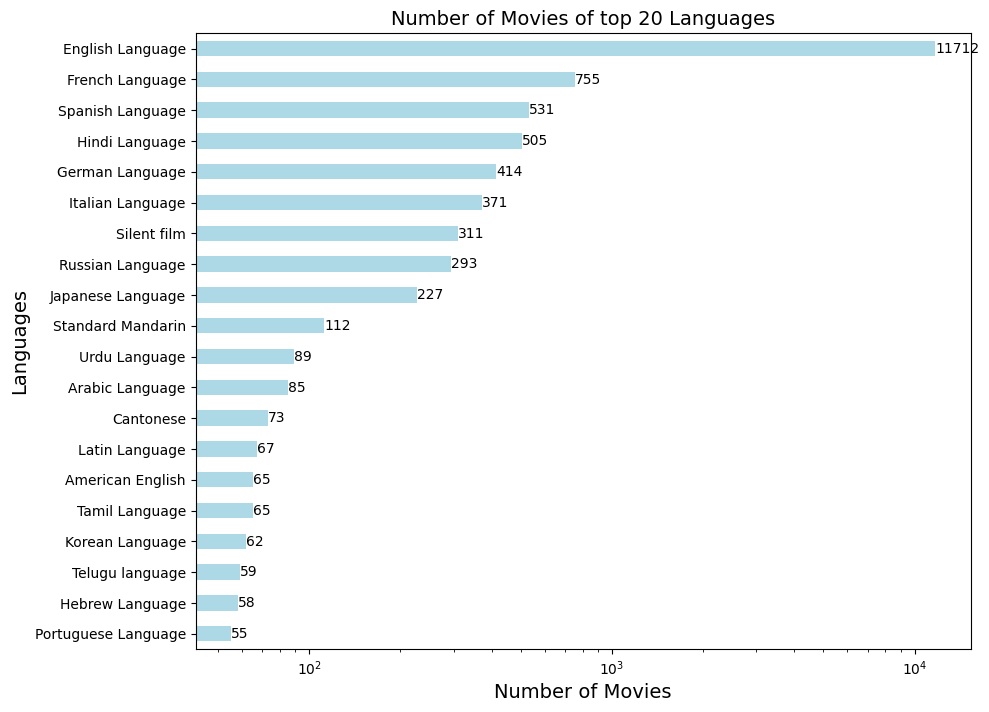

In [57]:
# Plot the number of movies per language
plt.figure(figsize=(10, 8))
bars = language_counts.head(20).sort_values(ascending=True).plot(kind='barh', color='lightblue')

for index, value in enumerate(language_counts.head(20).sort_values(ascending=True)):
    plt.text(value, index, str(value), va='center')

plt.xlabel('Number of Movies',fontsize=14)
plt.ylabel('Languages',fontsize=14)
plt.title('Number of Movies of top 20 Languages', fontsize=14)
plt.xscale('log')
plt.show()

As previously seen, English is largely dominant. This can be attributed to its role as a global lingua franca, making films more accessible to international audiences. Additionally, major movie industries in countries like the US and other English-speaking regions contribute to the high number of English-language films.

For better visibility, we chose to display only the top 20 languages in this chart. It is also noticeable that the number of movies per language drops off quickly after the most common languages, highlighting the dominance of a few major languages in movie production and a long tail of less commonly represented languages. For better readibility we used a log scale on the x axis.

### Movies release year exploration

Here we do a general analysis about the total number of movies released each year.

In [58]:
all_years = movie_final['Movie release date'].explode()
years_counts = all_years.value_counts()
all_years.describe()

,Movie release date
count,14253.000000
mean,1982.087911
std,26.228790
min,1899.000000
25%,1965.000000
50%,1990.000000
75%,2004.000000
max,2016.000000


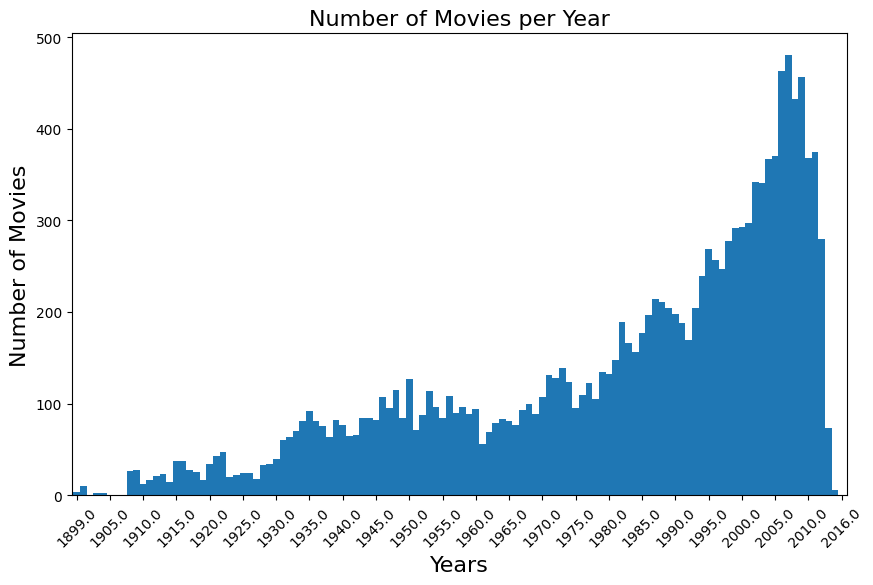

In [59]:
# Number of movies per year

plt.figure(figsize=(10, 6))
plot_years_counts = all_years.value_counts().sort_index().plot(kind='bar', width=1)

plt.xlabel('Years', fontsize=16 )
plt.ylabel('Number of Movies', fontsize=16)
plt.title('Number of Movies per Year', fontsize=16)

plt.xticks(range(0, len(all_years.value_counts().sort_index()), 5),
           all_years.value_counts().sort_index().index[::5],
           rotation=45)

plt.show()

The movie production has grown steadily over time, with a big jump starting in the 1990s and peaking in the early 2000s. The increase after the 1980s is likely due to better technology and more people making movies around the world. The early years have fewer movies because the film industry was just getting started. Data starting from 2012 is incomplete (e.g. the dataset contains only one movie in 2016).

### Movies per decade for most important countries

In [60]:
# Get top 10 countries releasing movies
top_10_countries = countries_counts.head(10).index

# Get one country per row (since some movies contain more than one country)
expanded_df = movie_final.explode('Movie countries')

top_countries_df = expanded_df[expanded_df['Movie countries'].isin(top_10_countries)]

In [61]:
top_countries_df = top_countries_df.copy()
# Using loc to safely add the 'Decade' column
top_countries_df.loc[:, 'Decade'] = (top_countries_df['Movie release date'] // 10) * 10

# Group by decade and country, count the number of movies
movies_per_decade_countries = top_countries_df.groupby(['Decade', 'Movie countries']).size().unstack(fill_value=0)

In [62]:
# Create the interactive figure
fig = go.Figure()

for country in movies_per_decade_countries.columns:
    fig.add_trace(go.Bar(
        x=movies_per_decade_countries.index, # Decades
        y=movies_per_decade_countries[country], # Number of movies
        name=country,
        hovertemplate='Percentage: %{customdata:.2f}%',
        customdata=100 * movies_per_decade_countries[country] / movies_per_decade_countries.sum(axis=1)
    ))

fig.update_layout(
    title='Proportion of Movies Produced by Top 10 Countries per Decade',
    xaxis_title='Decade',
    yaxis_title='Number of Movies',
    barmode='stack',
    legend_title='Country',
    hovermode='x'
)

fig.show()


The U.S. consistently dominates movie production across all decades, though its share decreases over time from near-total dominance in the early 20th century to around 40-50% in the later decades. Other countries, such as India, the UK, and France, start contributing more significantly from the 1950s onward, indicating a diversification in global movie production over the decades.

### How do the genres of the released movies vary depending on the decade?

In [63]:
# Get top 20 genres releasing movies
top_20_genres = genres_counts.head(20).index

# Get one country per row
expanded_df_genre = movie_final.explode('Movie genres')

# The top 20
top_genres_df_20 = expanded_df_genre[expanded_df_genre['Movie genres'].isin(top_20_genres)]

movies_per_year_genres_20 = top_genres_df_20.groupby(['Movie genres', 'Movie release date']).size().unstack(fill_value=0)
# Remove the first decade (1890s) from the movies per decade data since it only has a few movies
movies_per_year_genres_20 = movies_per_year_genres_20.loc[:, movies_per_year_genres_20.columns >= 1900]
# Remove the last decade (2010s) from the movies per decade data since it has missing years
movies_per_year_genres_20 = movies_per_year_genres_20.loc[:, movies_per_year_genres_20.columns < 2010]
movies_per_decade_genres_20 = movies_per_year_genres_20.groupby((movies_per_year_genres_20.columns // 10) * 10, axis=1).sum()


movies_per_decade_genres_20_percentage = movies_per_decade_genres_20.div(movies_per_decade_genres_20.sum(axis=1), axis=0)

<ipython-input-63-60fa59413527>:15: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



We decide to keep only the top 20 genres so that our graph stay clear but you can adjust this number if needed.

In [64]:
movies_per_decade_by_genre = movies_per_decade_genres_20.T

# Ensure your DataFrame `movies_per_decade_by_genre_normalized` is defined and normalized
movies_per_decade_by_genre_normalized = movies_per_decade_by_genre.div(movies_per_decade_by_genre.sum(axis=1), axis=0)

In [65]:
# Create an interactive figure
import plotly.express as px
fig = go.Figure()

# Iterate through each decade and create a bar plot for it
for decade in movies_per_decade_by_genre_normalized.index:
    fig.add_trace(go.Bar(
        x=movies_per_decade_by_genre_normalized.columns,
        y=movies_per_decade_by_genre_normalized.loc[decade], # Convert to percentage
        name=f'{decade}s',
        visible=False # Initially set all traces to invisible
    ))

# Set the first decade to be visible
fig.data[0].visible = True

# Create the slider steps
steps = []
for i, decade in enumerate(movies_per_decade_by_genre_normalized.index):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}], # Hide all traces
        label=f"{decade}s"
    )
    step["args"][0]["visible"][i] = True # Set the current decade's trace to visible
    steps.append(step)

# Determine the maximum value for the y-axis
max_y_value = movies_per_decade_by_genre_normalized.max().max()

# Create slider
sliders = [dict(
    active=0,
    currentvalue={"prefix": "Decade: "},
    pad={"t": 50},
    steps=steps
)]

# Update the layout to include the slider and fix y-axis range
fig.update_layout(
    sliders=sliders,
    title='Proportion of Movies Released by Genre in Each Decade',
    xaxis_title='Genre',
    yaxis_title='Percentage of Movies',
    yaxis=dict(
        tickformat=".1%",
        range=[0, max_y_value] # Fix y-axis range from 0 to the maximum value
    ),
    barmode='group',
    width=1000, # Set figure width
    height=600 # Set figure height
)

# Show the plot
fig.show()


From the 1900s to the 1970s we go from 25% to nearly 0% of Black-and-White movies, this is naturally due to the creation of color cinema in the 1902. It is once again easy to notice the consistant prevalence of the drama genre which only gets smaller due to the arrival of more nuenced genres in the 1920s. Indie movies are popular from the 1900s to the 1920s and later never rise above 5%. Starting from the 1930s, comedy, romance and thrillers keep a steady popularity.

In [66]:
fig = go.Figure()

# Loop through each genre to add a bar trace for it
for genre in movies_per_decade_genres_20_percentage.index:
    fig.add_trace(go.Bar(
        x=movies_per_decade_genres_20_percentage.columns, # Decades
        y=movies_per_decade_genres_20_percentage.loc[genre], # Percentage values for each decade
        name=genre,
        visible=False # Initially set all traces to invisible
    ))

# Set the first genre to be visible
fig.data[0].visible = True

# Create slider steps, each step corresponding to a genre
steps = []
for i, genre in enumerate(movies_per_decade_genres_20_percentage.index):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}], # Start by hiding all traces
        label=genre
    )
    # Set the current genre's trace to be visible
    step["args"][0]["visible"][i] = True
    steps.append(step)

# Define the slider with steps for each genre
sliders = [dict(
    active=0,
    currentvalue={"prefix": "Genre: "},
    pad={"t": 50},
    steps=steps
)]

# Update layout to include the slider and labels
fig.update_layout(
    sliders=sliders,
    title='Proportion of Movies Released per Decade by Selected Genre',
    xaxis_title='Decade',
    yaxis_title='Percentage of Movies',
    yaxis=dict(tickformat=".1%", range=[0, 0.5]), # Ensuring y-axis is consistently scaled
    width=900,
    height=500
)

# Show the plot
fig.show()

Thanks to this plot it is much easier to see how the different movie genres' popularity fare through time. Do keep in mind that new movie genres appear through the years which causes an inevitable small decrease of movies in a each category even if their respective popularity might not change.

# Part 3: Latent Dirichlet Allocation (LDA)
To group movies together based on something more precise than their genre, we will use Latent Dirichlet Allocation. LDA offers a way to cluster together movies that reflect similar themes, based on textual descriptions. The model is based on unsupervised learning, as the subjects are not known. However the movie summaries only give us too few informations to use LDA. That's why we will extract the synopsis of the movies through another dataset called "Movie Plot Synopses with Tags" (MPST). Those synopsis are around 10 times longer than the summaries, giving way more informations to the LDA model.

## 3.1 Can we observe movies' topics using LDA?

### Preprocessing
Removing stop words and names before using LDA is important as those very frequent words are not used to predict themes + lowercase

**Note:** The following cell performs named entity removal and stopword filtering on movie synopses. It takes a while to run, since it processes a large dataset. To skip this cell you can use the preprocessed sentences saved in `Data/processed_sentences.plk` instead by setting `run_processing` to `False`.


In [67]:
# Set this to False to use precomputed processed_sentences.plk
run_processing = False

if run_processing:

    # Get all synopses
    sentences = movies_synopsis['plot_synopsis'].tolist()

    # Lower case, Remove stop words and named entities
    processed_sentences = synopses_processing(sentences)

    # Save processed sentences to a file
    with open("Data/processed_sentences.pkl", "wb") as file:
        pickle.dump(processed_sentences, file)
else:
    # Load all processed data
    with open("Data/processed_sentences.pkl", "rb") as file:
        processed_sentences = pickle.load(file)


# Pre-process P3

### Preprocessing

LDA works with feature vectors and also some words are not relevant for topic prediction.

### explain nlp pipeline
1.   Tokenization
2.   Remove stop words
2.   Lemmatization
3.   Remove named entities
4.   Chunking??
4.   Convert to lowercase


Removing stop words and names before using LDA is important as those very frequent words are not used to predict themes + lowercase

In [75]:
reduced_df = movie_final.iloc[0:-1] #For tests on smaller dataset

synopses = reduced_df['plot_synopsis'].tolist()
movie_ids = reduced_df['imdb_id'].tolist()
print(len(synopses))

14252


Load the spacy analyzer in English

In [73]:
nlp = spacy.load("en_core_web_sm")
nlp.remove_pipe("parser") #We don't need the parser (win comp. time)

('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x79c23cc11000>)

In [74]:
#I will make it as a function
from tqdm import tqdm
#spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS #usefull if we want to change the stop word list
processed_docs = list()
for doc in tqdm(nlp.pipe(synopses, n_process=5, batch_size=10)):

    # Process document using Spacy NLP pipeline.
    ents = doc.ents  # Named entities
    '''for ent in ents:
        print(ent.text, ent.label_)'''
    # Lemmatize tokens (running --> run) after removing numbers, punctuation, stopwords and entities.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and len(token) > 2 and token.ent_type_ == ""]

    '''    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in spacy_stopwords ]'''

    # Add named entities, but only if they are not character names and longer than 1 word (as it's usually character names not recognized as PERSON).
    doc.extend([str(entity) for entity in ents if len(entity) > 1 and entity.label_ != "PERSON"])

    processed_docs.append(doc)
docs = processed_docs
del processed_docs
#runtime = 47min

5030it [20:39,  4.14it/s]Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Process Process-3:
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Process Process-4:
  File "/usr/local/lib/python3.10/dist-packages/spacy/language.py", line 2375, in _apply_pipes
    sender.send(data)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 405, in _send_bytes
    self._send(buf)
Traceback (most recent call last):
  File "/usr/

KeyboardInterrupt: 

In [ ]:
# Add bigrams too (maybe trigrams also ?)
from gensim.models.phrases import Phrases

# Add bigrams to docs (only ones that appear 15 times or more).
bigram = Phrases(docs, min_count=15)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
'''#Take only synopsis with 5 tokens as LDA needs this
docs = [doc for doc in docs if len(doc) > 5]'''

In [ ]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)

# Remove too rare and too common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
coherence_scores = []

## Number of topics selection

To select the number of topics we use the coherence score. To do so we use the Word2Vec model for coherence score. Eventhough the whole LDA pipeline was made using gensim models, its coherence is depriciated [check here](https://www.baeldung.com/cs/topic-modeling-coherence-score).

The working principle is quite intuitive:
* Maximize intra-topic similarity: similarity of words in the same topic.

* Minimize Inter-topic similarity: the similarity of words across different topics.

In [ ]:
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
seed = 42
params = {'passes': 10, 'random_state': seed}
base_models = dict()
topics = range(5, 20, 2)
topics2 = range(1, 5, 1)
coherence_scores_1to4 = []
#
for topic in tqdm(topics2):
    model = LdaMulticore(corpus=corpus, num_topics=topic, id2word=dictionary, workers=6,
                    passes=params['passes'], random_state=params['random_state'])
    coherence_model = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
    coherence_scores_1to4.append(coherence_model.get_coherence())


In [ ]:
for topic_id, topic_words in model.print_topics(num_words=10):
    print(f"Topic {topic_id}: {topic_words}")
print(f"Coherence = {coherence_model.get_coherence()}")

In [ ]:
topics = range(5, 22, 2)
plt.plot(topics, coherence_scores, c='b')
plt.plot(topics2, coherence_scores_1to4, c='b')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')

In [ ]:
import pyLDAvis.gensim_models
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

**Note:** The following cell builds a dictionary from the processed sentences, converts those sentences into a bag-of-words representation, and then trains an LDA model to extract 10 topics from the text data. It takes a while to run, since it processes a large dataset. To skip this cell you can use the precomputed model saved in `Data/lda_model.model` instead by setting `run_processing` to `False`.

### LDA model

In [ ]:
# Set this to False to use precomputed processed_sentences.plk
run_processing = False

if run_processing:
    # Maps each word to a unique integer ID
    dictionary = Dictionary(processed_sentences)

    # Convert sentences into a bags of words (BoW)
    corpus = [dictionary.doc2bow(sentence) for sentence in processed_sentences]

    # Train LDA model
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=42, passes=10, iterations=50)

    # Save dic and model
    lda_model.save("src/models/lda_model.model")
    dictionary.save("src/models/dictionary.dict")
else:
    lda_model = LdaModel.load("src/models/lda_model.model")

### Resulting Topcis
Let's now look at what 10 topics the movies were clustered in

In [ ]:
for topic_id, topic_words in lda_model.print_topics(num_words=7):
    print(f"Topic {topic_id}: {topic_words}")

Here the different words are grouped by their common topic. The numbers in front of the words denote how frequently the words appear among the movies' synopsis (in decreasing order).

### Is this approach feasible with our data?
This approcah seems promising! With very basic preprocessing can already interpret some themes:


| Topic | Keywords                       | Theme           |
|-------|--------------------------------|-----------------|
| 0     | Police, Kill, Detective        | Detective       |
| 1     | War, Team                      | War             |
| 2     | Hamlet, Macbeth                | Shakespeare     |
| 3     | Father, Love                   | Family          |
| 4     | Town, Sheriff, Horse           | Western         |
| 5     | Ship, Treasure                 | Pirate          |
| 6     | Prince, Castle                 | Fairy Tale      |
| 7     | Money, Job                     | Business        |
| 8     | ?                              | ?               |
| 9     | ?                              | ?               |

### Observations and Improvements
But we also observe that this still has room for improvement:

- Topics 9 still carries many names thus for further analysis the `named entity removal` step should be fine tuned.

- `Lemmatization` should be applied to avoid reoccurences of declinaison of the same word (e.g killed and kill in topic 0).

- The `parameters` such as number of topics, passes and the number of iterations are not chosen optimally which leaves room for improvement.  